# Visualisation of UK COVID-19 cases

Download daily updated CSV with cases for upper/lower tier local authorities from https://coronavirus.data.gov.uk<br/>
Only cases for pillar 1 are currently included.

In [1]:
# Download latest CSV file with wget
import wget
import os

# Remove previous data
if os.path.exists("coronavirus-cases_latest.csv"):
  os.remove("coronavirus-cases_latest.csv")

url      = "https://c19downloads.azureedge.net/downloads/csv/coronavirus-cases_latest.csv"
filename = wget.download(url)

In [2]:
# Load and store CSV data as dictionary
from csv import DictReader
# open file in read mode
with open('coronavirus-cases_latest.csv', 'r') as read_obj:
    # pass the file object to DictReader() to get the DictReader object
    dict_reader = DictReader(read_obj)
    # get a list of dictionaries from dct_reader
    covid_dict = list(dict_reader)

In [3]:
# Generate list of dates from end of January 2020 to today
import pandas as pd
from datetime import datetime

datelist = pd.date_range(start="2020-01-30",end=datetime.today().strftime('%Y-%m-%d'))

In [4]:
# Extract data for certain regions and save to common array
import numpy as np
        
# selected regions:
# England/South West/Bristol/South Gloucestershire/Bath and North East Somerset/North Somerset
cases_selected = np.empty((len(datelist),6,3))
cases_selected[:,:] = np.nan
for x,index in enumerate(covid_dict):
    if(index['Area name'] == 'England' and index['Area type'] == 'Nation'): 
        region_idx = 0
    elif(index['Area name'] == 'South West' and index['Area type'] == 'Region'): 
        region_idx = 1
    elif(index['Area name'] == 'Bristol, City of' and index['Area type'] == 'Upper tier local authority'): 
        region_idx = 2
    elif(index['Area name'] == 'South Gloucestershire' and index['Area type'] == 'Upper tier local authority'): 
        region_idx = 3
    elif(index['Area name'] == 'Bath and North East Somerset' and index['Area type'] == 'Upper tier local authority'): 
        region_idx = 4
    elif(index['Area name'] == 'North Somerset' and index['Area type'] == 'Upper tier local authority'): 
        region_idx = 5
    else:
        continue
    time_idx = (datelist == pd.Timestamp(index['Specimen date'])).argmax()
    cases_selected[time_idx,region_idx,0] = index['Daily lab-confirmed cases']
    cases_selected[time_idx,region_idx,1] = index['Cumulative lab-confirmed cases']
    cases_selected[time_idx,region_idx,2] = index['Cumulative lab-confirmed cases rate']

# fill missing values for cumulative cases with previous values
for tt,date in enumerate(datelist):
    for ii in range(0,6):
        if np.isnan(cases_selected[tt,ii,1]):
            cases_selected[tt,ii,1] = cases_selected[tt-1,ii,1]
            cases_selected[tt,ii,2] = cases_selected[tt-1,ii,2]

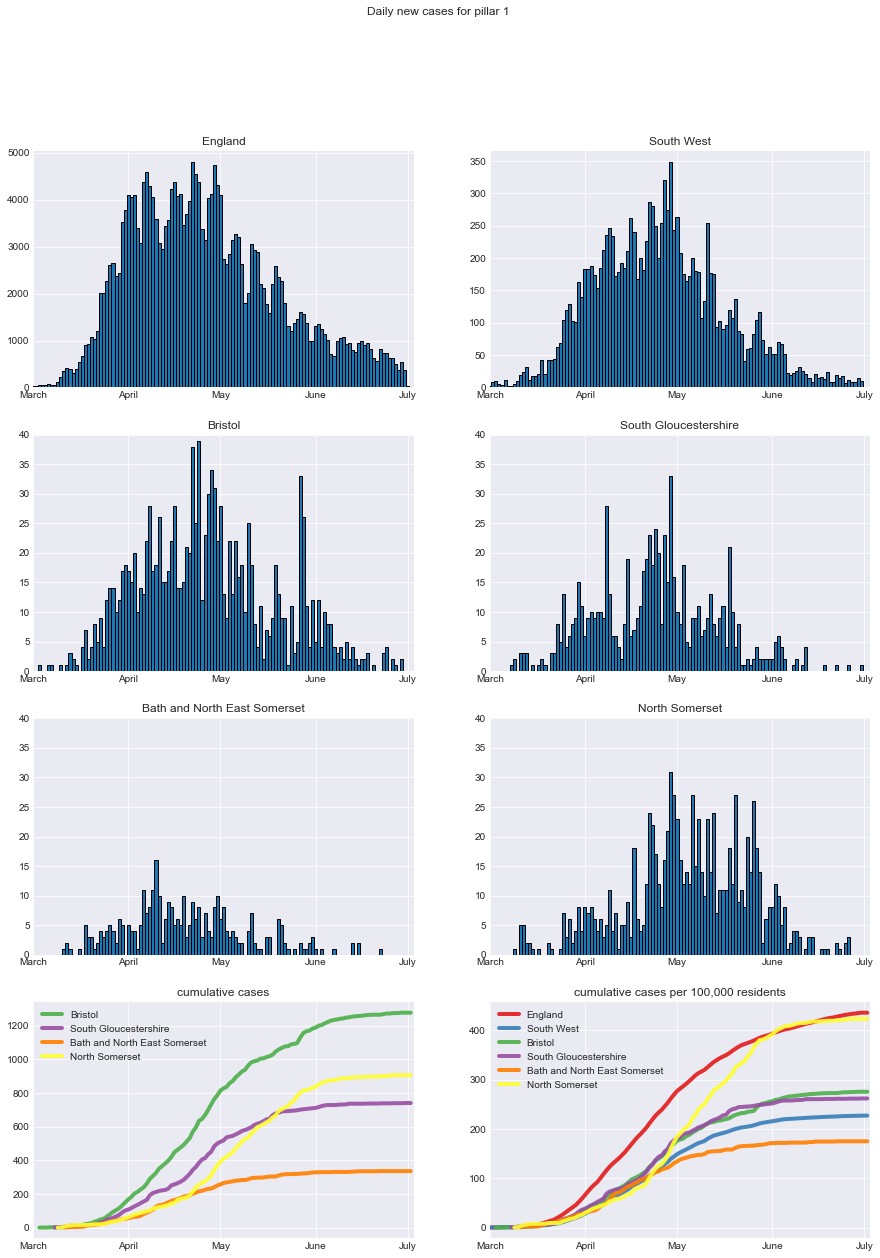

In [6]:
# Plot Bristol cases as bar chart
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import datetime
import numpy as np
import seaborn as sns

start_date = datetime.date(2020, 3, 1)
end_date   = datetime.datetime.now()

region_labels = ["England","South West","Bristol","South Gloucestershire","Bath and North East Somerset","North Somerset"]

fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(15,20))
fig.suptitle('Daily new cases for pillar 1')
fig.subplots_adjust(hspace = 0.2)

for i in range(0, 3):
    axes[i,0].set_title(region_labels[i*2])
    axes[i,1].set_title(region_labels[i*2+1])
    axes[i,1].set_xlim(dates.date2num(start_date),dates.date2num(end_date))
    axes[i,0].set_xlim(dates.date2num(start_date),dates.date2num(end_date))
    if i > 0:
        axes[i,1].set_ylim(0,40)
        axes[i,0].set_ylim(0,40)
    axes[i,1].xaxis.set_major_formatter(dates.DateFormatter("%B"))
    axes[i,0].xaxis.set_major_formatter(dates.DateFormatter("%B"))
    axes[i,1].xaxis.set_major_locator(dates.MonthLocator())
    axes[i,0].xaxis.set_major_locator(dates.MonthLocator())
    axes[i,0].bar(datelist,cases_selected[:,i*2,0],1.0,edgecolor = "black")
    axes[i,1].bar(datelist,cases_selected[:,i*2+1,0],1.0,edgecolor = "black")

# style
plt.style.use('seaborn-darkgrid')
# create a color palette
palette = plt.get_cmap('Set1')

axes[3,0].set_title("cumulative cases")
num=0
for i in range(0, 4):
    axes[3,0].plot(datelist, cases_selected[:,2+i,1], marker='', color=palette(i+2), linewidth=4, alpha=0.9, label=region_labels[2+i])
axes[3,0].set_xlim(dates.date2num(start_date),dates.date2num(end_date))
axes[3,0].xaxis.set_major_formatter(dates.DateFormatter("%B"))
axes[3,0].xaxis.set_major_locator(dates.MonthLocator())
axes[3,0].legend(loc=2, ncol=1)

axes[3,1].set_title("cumulative cases per 100,000 residents")
num=0
for i in range(0, 6):
    axes[3,1].plot(datelist, cases_selected[:,i,2], marker='', color=palette(i), linewidth=4, alpha=0.9, label=region_labels[i])
axes[3,1].set_xlim(dates.date2num(start_date),dates.date2num(end_date))
axes[3,1].xaxis.set_major_formatter(dates.DateFormatter("%B"))
axes[3,1].xaxis.set_major_locator(dates.MonthLocator())
axes[3,1].legend(loc=2, ncol=1)
